### Import Lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import product

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

### Read Dataset

In [2]:
df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv')
new_name = []
for i in range(1, 189):
    new_name.append(str(i) + '_time')
df.columns = new_name
df = df.rename(columns={'188_time': 'Targets'})
df.head(5)

,1_time,2_time,3_time,4_time,5_time,6_time,7_time,8_time,9_time,10_time,...,179_time,180_time,181_time,182_time,183_time,184_time,185_time,186_time,187_time,Targets
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Preparing

In [3]:
train = df.drop(['Targets'], axis = 1)
label = df['Targets']

x_train, x_val, y_train, y_val = train_test_split(train, label, test_size = 0.3, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 2/3, random_state = 42)
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)
x_train.shape, y_train.shape,x_val.shape, y_val.shape, x_test.shape, y_test.shape

((61287, 187), (61287,), (8755, 187), (8755,), (17511, 187), (17511,))

In [4]:
X_train = torch.from_numpy(x_train.values).float().reshape(-1, 1, 187)
Y_train = torch.from_numpy(y_train.values).long()

X_val = torch.from_numpy(x_val.values).float().reshape(-1, 1, 187)
Y_val = torch.from_numpy(y_val.values).long()

X_test = torch.from_numpy(x_test.values).float().reshape(-1, 1, 187) 
Y_test = torch.from_numpy(y_test.values).long()

# Tạo DataLoader
batch_size = 32
dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Create and Engine

- Model define

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons, learning_rate, optimizer, output_size=5):
        super(LSTMModel, self).__init__()
        
        seed_value = 42
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        
        self.lstm_layers = nn.ModuleList()
        for _ in range(hidden_layers):
            self.lstm_layers.append(nn.LSTM(input_size, neurons, batch_first=True))
            input_size = neurons
        
        self.output_layer = nn.Linear(neurons, output_size)
        
    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        x = self.output_layer(x[:, -1, :])
        return x


class CNNModel(nn.Module):
    def __init__(self, input_channels, input_length, conv_layers, neurons, learning_rate, optimizer, output_size=5):
        super(CNNModel, self).__init__()
        
        seed_value = 42
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels
        
        # Thêm các lớp conv
        for _ in range(conv_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(in_channels, neurons, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2)
            ))
            in_channels = neurons
        
    
        reduced_length = input_length // (2 ** conv_layers) 
        self.fc_input_size = neurons * reduced_length
        
        self.output_layer = nn.Linear(self.fc_input_size, output_size)
    def forward(self, x):
        for conv in self.conv_layers:
            x = conv(x)
        
        x = x.view(x.size(0), -1)
        x = self.output_layer(x)
        return x

In [6]:
def Create_CAT(learning_rate, depth, l2_leaf_reg, border_count):
    return CatBoostClassifier(learning_rate = learning_rate, depth = depth, 
                              l2_leaf_reg = l2_leaf_reg, border_count = border_count,
                              iterations=5000, verbose = 500, early_stopping_rounds = 30, #thread_count = -1,
                              random_state = 42, eval_metric='Accuracy', task_type='GPU', devices='0')

def Create_LSTM(hidden_layers, neurons, learning_rate, optimizer):
    return LSTMModel(187, hidden_layers, neurons, learning_rate, optimizer)

def Create_CNN(conv_layers, neurons, learning_rate, optimizer):
    return CNNModel(1, 187, conv_layers, neurons, learning_rate, optimizer)

- Engine

In [7]:
def Training(num_epochs, model, optimizer, loss_fn, train_loader, val_loader = None, early_stopping = False, patience = 5):
    batch_size = train_loader.batch_size
    total_batch = len(train_loader.dataset) / batch_size
    total_batch = int(total_batch + 1) if total_batch.is_integer() == False else int(total_batch)

    if early_stopping == True:
        best_valid_loss = float('inf')
        current_patience = 0
    if torch.cuda.is_available():
          model=model.cuda()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            res = model(images)
            loss = loss_fn(res, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(res.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('\r'f"Epoch {epoch+1}: {int(((i+1) / total_batch) * 100)}%\t{i+1}/{total_batch}", end='\t')
        
        running_loss /= len(train_loader)
        accuracy = 100 * correct / total
        # Validation phase
        if val_loader is not None:
            model.eval()
            val_running_loss = 0.0
            val_total = 0
            val_correct = 0

            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    if torch.cuda.is_available():
                        val_images, val_labels = val_images.cuda(), val_labels.cuda()

                    val_res = model(val_images)
                    val_loss = loss_fn(val_res, val_labels)

                    val_running_loss += val_loss.item()
                    _, val_predicted = torch.max(val_res.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()
            
            val_running_loss /= len(val_loader)
            val_accuracy = 100 * val_correct / val_total
            print(f'Epoch {epoch + 1}, Train_Loss: {running_loss}, Train_Accuracy: {accuracy}, Val_Loss = {val_running_loss}, Val_Accuracy: {val_accuracy}')
            #check early_stopping
            if early_stopping == True:
                if val_running_loss < best_valid_loss:
                    best_valid_loss = val_running_loss
                    current_patience = 0
                else:
                    current_patience += 1
                if current_patience > patience:
                    print(f'Early stopping after {epoch+1} epochs')
                    break
        else: print(f'Epoch {epoch + 1}, Train_Loss: {running_loss}, Train_Accuracy: {accuracy}')
    print('Training finished')
    
def Evaluate(model, test_loader, true_labels, Show_all = False):
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
    import torch.nn.functional as F
    batch_size = test_loader.batch_size
    total_batch = len(test_loader.dataset) / batch_size
    total_batch = int(total_batch + 1) if total_batch.is_integer() == False else int(total_batch)
    
    if torch.cuda.is_available():
        model = model.cuda()
    model.eval()
    correct = 0
    total = 0
    pred = []
    prob_all = []
    true = true_labels
        
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            
            probabilities = F.softmax(outputs, dim=1)
            prob_all.extend(probabilities.cpu().tolist())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pred.extend(predicted.tolist())
            print('\r'f"{int(((i+1) / total_batch) * 100)}%\t{i+1}/{total_batch}", end='\t')

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy}')
    f1 = f1_score(true, pred, average = 'macro')
    
    if Show_all == True:
        print(classification_report(pred, true, digits = 4))
    return pred, accuracy, f1, prob_all

### Genetic Algorithm

In [ ]:
def GA_loops(population_size, population):
    score_populations = []
    C = 1
    previous_parents = None

    for i in range(population_size):
        print(f'quần thể thứ {i + 1}: ', population)
        # đánh giá cá thể
        fitness_scores = [evaluate_fitness(ind) for ind in population]
        print("--- Điểm fitness f1 của từng cá thể trên tập test:", fitness_scores)

        # Lưu score của cá thể tốt nhất
        best_score = max(fitness_scores)
        score_populations.append(best_score)

        # Chọn hai cá thể tốt nhất để lai tạo
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
        parent1, parent2 = sorted_population[:2]

        # Kiểm tra có bị trùng parent không
        if previous_parents == (parent1, parent2):
            C += 1
        else:
            C = 1
        previous_parents = (parent1, parent2)
        print('kiểm tra bị trùng cặp bố mẹ: ', C)

        # Điều kiện dừng: nếu C = 15 hoặc parent1 trùng với parent2
        if C == 15:
            print("Dừng lại vì điều kiện dừng C = 15 đã thỏa mãn.")
            break

        # Tạo con và đột biến
        children = crossover(parent1, parent2)
        if len(children) < 8: # Số lượng cá thể được tạo ra dưới 8
            additional_children = create_population(8 - len(children))  # Tạo số lượng cần thiết
            children += additional_children

        mutated_children = child_mutating(children, C) # Đột biến

        # Quần thể mới 
        population = [parent1, parent2] + mutated_children
    return score_populations, [parent1, parent2]

- Catboost

In [ ]:
def mutation(child, C):
    mutation_rate = min(0.1 * C, 1.0)
    if random.random() < mutation_rate:
        mut_idx = random.random()
        if C > 5:
            child[0] = random.uniform(1e-3, 0.5)
            child[1] = np.random.randint(4, 10)
            child[2] = np.random.randint(3, 15)
            child[3] = np.random.randint(30, 600)
        else:
            if mut_idx < 0.8:
                if mut_idx < 0.6:
                    if mut_idx < 0.4:
                        if mut_idx < 0.2:
                            child[0] = random.uniform(1e-3, 0.5)
                        else:
                            child[1] = np.random.randint(4, 10)
                    else:
                        child[2] = np.random.randint(3, 15)
                else:
                    child[3] = np.random.randint(30, 600)

            else:
                child[0] = random.uniform(1e-3, 0.5)
                child[1] = np.random.randint(4, 10)
                child[2] = np.random.randint(3, 15)
                child[3] = np.random.randint(30, 600)
        
    return child

def crossover(parent1, parent2):
    combinations = []
    for selection in product([0, 1], repeat=4):
        combination = [parent1[i] if selection[i] == 0 else parent2[i] for i in range(4)]
        if combination != parent1 and combination != parent2:  # Loại bỏ trường hợp chọn toàn bộ từ A hoặc toàn bộ từ B
            combinations.append(combination)
    unique_combinations = [list(item) for item in set(tuple(row) for row in combinations)]
    return unique_combinations

def child_mutating(list_child, C):
    mut_child = []
    for child in list_child:
        new_child = mutation(child.copy(), C)
        mut_child.append(new_child)
    return mut_child

def evaluate_fitness(individual):
    learning_rate, Depth, l2_leaf_reg, border_count = individual
    model = Create_CAT(learning_rate, Depth, l2_leaf_reg, border_count)
    
    # Huấn luyện mô hình
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    
    f1 = f1_score(pred, y_val, average = 'macro')
    return f1

In [ ]:
population_size = 9
origin = [0.1544319987297058, 6, 3, 128] # thêm vào cá thể với tham số mặc định

def create_population(population_size):
    population = []
    for _ in range(population_size):
        learning_rate = random.uniform(1e-3, 0.5)
        Depth = np.random.randint(4, 10)
        l2_leaf_reg = np.random.randint(3, 15)
        border_count = np.random.randint(30, 600)
        population.append([learning_rate, Depth, l2_leaf_reg, border_count])
    return population
population = create_population(population_size)
population.append(origin)

score_populations, parents = GA_loops(50, population)
print(score_populations)
print(parents)

with open("parent_cat.txt", "w") as file:
    for item in parents:
        file.write(f"{item}\n")

with open("score_cat.txt", "w") as file:
    for item in score_populations:
        file.write(f"{item}\n")

- LSTM

In [ ]:
optimizer_options = ['Adam','SGD', 'AdamW', 'RMSprop', 'Adadelta', 'Adamax', 'Nadam']

def mutation(child, C):
    mutation_rate = min(0.1 * C, 1.0)
    if random.random() < mutation_rate:
        mut_idx = random.random()
        if C > 5:
            child[0] = np.random.randint(1, 5)
            child[1] = np.random.randint(32, 512)
            child[2] = random.uniform(1e-3, 1e-1)
            child[3] = random.choice(optimizer_options)
        else:
            if mut_idx < 0.8:
                if mut_idx < 0.6:
                    if mut_idx < 0.4:
                        if mut_idx < 0.2:
                            child[0] = np.random.randint(1, 5)
                        else:
                            child[1] = np.random.randint(32, 512)
                    else:
                        child[2] = random.uniform(1e-3, 1e-1)
                else:
                    child[3] = random.choice(optimizer_options)

            else:
                child[0] = np.random.randint(1, 5)
                child[1] = np.random.randint(32, 512)
                child[2] = random.uniform(1e-3, 1e-1)
                child[3] = random.choice(optimizer_options)
        
    return child

def crossover(parent1, parent2):
    combinations = []
    for selection in product([0, 1], repeat=4):
        combination = [parent1[i] if selection[i] == 0 else parent2[i] for i in range(4)]
        if combination != parent1 and combination != parent2:  # Loại bỏ trường hợp chọn toàn bộ từ A hoặc toàn bộ từ B
            combinations.append(combination)
    unique_combinations = [list(item) for item in set(tuple(row) for row in combinations)]
    return unique_combinations

def child_mutating(list_child, C):
    mut_child = []
    for child in list_child:
        new_child = mutation(child.copy(), C)
        mut_child.append(new_child)
    return mut_child

def evaluate_fitness(individual):
    hidden_layers, neurons, learning_rate, optimizer = individual
    model = Create_LSTM(hidden_layers, neurons, learning_rate, optimizer)
    
    # optimizer
    if model.optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=model.learning_rate)
    elif model.optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=model.learning_rate, momentum=0.9)
    elif model.optimizer == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=model.learning_rate, weight_decay=0.01)
    elif model.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=model.learning_rate, alpha=0.99)
    elif model.optimizer == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(), rho=model.learning_rate)
    elif model.optimizer == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=model.learning_rate)
    elif model.optimizer == 'Nadam':
        optimizer = optim.NAdam(model.parameters(), lr=model.learning_rate)
        
    # Huấn luyện mô hình
    loss_function = nn.CrossEntropyLoss()
    Training(3, model, optimizer, loss_function, train_loader)
    _, _, f1, _ = Evaluate(model, val_loader, y_val)
    return f1

In [ ]:
population_size = 10

def create_population(population_size):
    population = []
    for _ in range(population_size):
        hidden_layers = np.random.randint(1, 5)
        neurons = np.random.randint(32, 512)
        learning_rate = random.uniform(1e-3, 1e-1)
        optimizer = random.choice(optimizer_options)
        population.append([hidden_layers, neurons, learning_rate, optimizer])
    return population
population = create_population(population_size)

score_populations, parents = GA_loops(50, population)
print(score_populations)
print(parents)


with open("parent_lstm.txt", "w") as file:
    for item in parents:
        file.write(f"{item}\n")

with open("score_lstm.txt", "w") as file:
    for item in score_populations:
        file.write(f"{item}\n")

- CNN

In [ ]:
optimizer_options = ['Adam','SGD', 'AdamW', 'RMSprop', 'Adadelta', 'Adamax', 'Nadam']

def mutation(child, C):
    mutation_rate = min(0.1 * C, 1.0)
    if random.random() < mutation_rate:
        mut_idx = random.random()
        if C > 5:
            child[0] = np.random.randint(1, 7)
            child[1] = np.random.randint(10, 512)
            child[2] = random.uniform(1e-4, 1e-1)
            child[3] = random.choice(optimizer_options)
        else:
            if mut_idx < 0.8:
                if mut_idx < 0.6:
                    if mut_idx < 0.4:
                        if mut_idx < 0.2:
                            child[0] = np.random.randint(1, 7)
                        else:
                            child[1] = np.random.randint(10, 512)
                    else:
                        child[2] = random.uniform(1e-4, 1e-1)
                else:
                    child[3] = random.choice(optimizer_options)

            else:
                child[0] = np.random.randint(1, 7)
                child[1] = np.random.randint(10, 512)
                child[2] = random.uniform(1e-4, 1e-1)
                child[3] = random.choice(optimizer_options)
        
    return child

def crossover(parent1, parent2):
    combinations = []
    for selection in product([0, 1], repeat=4):
        combination = [parent1[i] if selection[i] == 0 else parent2[i] for i in range(4)]
        if combination != parent1 and combination != parent2:  # Loại bỏ trường hợp chọn toàn bộ từ A hoặc toàn bộ từ B
            combinations.append(combination)
    unique_combinations = [list(item) for item in set(tuple(row) for row in combinations)]
    return unique_combinations

def child_mutating(list_child, C):
    mut_child = []
    for child in list_child:
        new_child = mutation(child.copy(), C)
        mut_child.append(new_child)
    return mut_child

def evaluate_fitness(individual):
    conv_layers, neurons, learning_rate, optimizer = individual
    model = Create_CNN(conv_layers, neurons, learning_rate, optimizer)
    
    # optimizer
    if model.optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=model.learning_rate)
    elif model.optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=model.learning_rate, momentum=0.9)
    elif model.optimizer == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=model.learning_rate, weight_decay=0.01)
    elif model.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=model.learning_rate, alpha=0.99)
    elif model.optimizer == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(), rho=model.learning_rate)
    elif model.optimizer == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=model.learning_rate)
    elif model.optimizer == 'Nadam':
        optimizer = optim.NAdam(model.parameters(), lr=model.learning_rate)
        
    # Huấn luyện mô hình
    loss_function = nn.CrossEntropyLoss()
    Training(2, model, optimizer, loss_function, train_loader)
    _, _, f1, _ = Evaluate(model, val_loader, y_val)
    return f1

In [ ]:
population_size = 10

def create_population(population_size):
    population = []
    for _ in range(population_size):
        conv_layers = np.random.randint(1, 7)
        neurons = np.random.randint(10, 512)
        learning_rate = random.uniform(1e-4, 1e-1)
        optimizer = random.choice(optimizer_options)
        population.append([conv_layers, neurons, learning_rate, optimizer])
    return population
population = create_population(population_size)

score_populations, parents = GA_loops(50, population)
print(score_populations)
print(parents)

with open("parent_cnn.txt", "w") as file:
    for item in parents:
        file.write(f"{item}\n")

with open("score_cnn.txt", "w") as file:
    for item in score_populations:
        file.write(f"{item}\n")

# Staking Ensemble

- Trainset for meta using cross validation

In [37]:
cnn_f1s = []
cnn_accs = []

lstm_f1s = []
lstm_accs = []

catboost_f1s = []
catboost_accs = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

meta_features = []
meta_labels = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, Y_train)):
    print(f"Fold {fold + 1}/5")
    
    # Data for catboost
    X_cat_train, X_cat_test = x_train.values[train_idx], x_train.values[test_idx]
    Y_cat_train, Y_cat_test = y_train.values[train_idx], y_train.values[test_idx]
    
    # Chia dữ liệu cho mỗi fold
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    Y_train_fold, Y_test_fold = Y_train[train_idx], Y_train[test_idx]
    
    # Tạo DataLoader cho train và test
    train_dataset = TensorDataset(X_train_fold, Y_train_fold)
    test_dataset = TensorDataset(X_test_fold, Y_test_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 1. Huấn luyện CNN
    cnn_model = Create_CNN(5, 509, 0.0005128042181144895, 'Nadam') # tham số tìm được sau khi tối ưu bằng GA
    optimizer = optim.NAdam(cnn_model.parameters(), lr=cnn_model.learning_rate)
    loss_function = nn.CrossEntropyLoss()
    Training(20, cnn_model, optimizer, loss_function, train_loader)
    _, cnn_acc, cnn_f1, cnn_proba = Evaluate(cnn_model, test_loader, Y_test_fold)
    
    # 2. Huấn luyện LSTM
    lstm_model = Create_LSTM(2, 502, 0.019630585812292045, 'Adamax') # tham số tìm được sau khi tối ưu bằng GA
    optimizer = optim.Adamax(lstm_model.parameters(), lr = lstm_model.learning_rate)
    loss_function = nn.CrossEntropyLoss()
    Training(20, lstm_model, optimizer, loss_function, train_loader)
    _, lstm_acc, lstm_f1, lstm_proba = Evaluate(lstm_model, test_loader, Y_test_fold)
    
    # 3. Huấn luyện CatBoost
    catboost_model = Create_CAT(0.4819641211153447, 9, 4, 47) # tham số tìm được sau khi tối ưu bằng GA
    catboost_model.fit(X_cat_train, Y_cat_train)
    cat_pred = catboost_model.predict(X_cat_test)
    
    catboost_acc = accuracy_score(Y_cat_test, cat_pred)
    catboost_f1 = f1_score(Y_cat_test, cat_pred, average = 'macro')
    catboost_proba = catboost_model.predict_proba(X_cat_test)
    
    # Metrics
    cnn_f1s.append(cnn_f1)
    cnn_accs.append(cnn_acc)

    lstm_f1s.append(lstm_f1)
    lstm_accs.append(lstm_acc)

    catboost_f1s.append(catboost_f1)
    catboost_accs.append(catboost_acc)
    
    # Kết hợp xác suất của các mô hình cơ bản
    fold_meta_features = np.hstack([cnn_proba, lstm_proba, catboost_proba])
    meta_features.append(fold_meta_features)
    meta_labels.extend(Y_cat_test)

# Chuyển meta_features thành mảng numpy
meta_features = np.vstack(meta_features)

Fold 1/5
Epoch 1: 100%	1533/1533	Epoch 1, Train_Loss: 0.18722777999208515, Train_Accuracy: 94.94176915702951
Epoch 2: 100%	1533/1533	Epoch 2, Train_Loss: 0.09233809320964782, Train_Accuracy: 97.434171612719
Epoch 3: 100%	1533/1533	Epoch 3, Train_Loss: 0.07130591947974078, Train_Accuracy: 97.85637071937016
Epoch 4: 100%	1533/1533	Epoch 4, Train_Loss: 0.05745394943217915, Train_Accuracy: 98.27449060759959
Epoch 5: 100%	1533/1533	Epoch 5, Train_Loss: 0.04736465616744399, Train_Accuracy: 98.56411511554386
Epoch 6: 100%	1533/1533	Epoch 6, Train_Loss: 0.041271882574442274, Train_Accuracy: 98.74360072610088
Epoch 7: 100%	1533/1533	Epoch 7, Train_Loss: 0.034178394966764614, Train_Accuracy: 98.94144281955577
Epoch 8: 100%	1533/1533	Epoch 8, Train_Loss: 0.02938940880768858, Train_Accuracy: 99.02506679720166
Epoch 9: 100%	1533/1533	Epoch 9, Train_Loss: 0.026985224911262318, Train_Accuracy: 99.10869077484755
Epoch 10: 100%	1533/1533	Epoch 10, Train_Loss: 0.02373036774183547, Train_Accuracy: 99.229

In [38]:
# Score từng fold
print('CNN F1:', cnn_f1s)
print('CNN acc:', cnn_accs)

print('LSTM F1:', lstm_f1s)
print('LSTM acc:', lstm_accs)

print('CAT F1:', catboost_f1s)
print('CAT acc:', catboost_accs)

CNN F1: [0.9235722683710781, 0.8972727923531499, 0.9040731919203966, 0.9121835236066083, 0.9098411174040194]
CNN acc: [98.58051884483602, 98.2705172132485, 98.4090723668108, 98.48249979603492, 98.36012074732805]
LSTM F1: [0.8868277122031781, 0.9104260858749382, 0.8835425002601365, 0.9117496029189353, 0.8993175161879361]
LSTM acc: [97.77288301517376, 98.00946320770109, 97.74006690054662, 98.1398384596557, 98.01745941094885]
CAT F1: [0.9092711664397568, 0.9219404302292942, 0.8997118643592874, 0.909622814937866, 0.9091807810187864]
CAT acc: [0.9814814814814815, 0.9835209658998205, 0.9818879007913845, 0.982051072856327, 0.9816431426939708]


In [40]:
new_name = ['cnn_proba_0','cnn_proba_1','cnn_proba_2','cnn_proba_3', 'cnn_proba_4', 'lstm_proba_0',
            'lstm_proba_1','lstm_proba_2', 'lstm_proba_3', 'lstm_proba_4','catboost_proba_0',
            'catboost_proba_1', 'catboost_proba_2','catboost_proba_3', 'catboost_proba_4']
train_meta_df = pd.DataFrame(meta_features, columns = new_name)
train_meta_df['labels'] = meta_labels
train_meta_df

,cnn_proba_0,cnn_proba_1,cnn_proba_2,cnn_proba_3,cnn_proba_4,lstm_proba_0,lstm_proba_1,lstm_proba_2,lstm_proba_3,lstm_proba_4,catboost_proba_0,catboost_proba_1,catboost_proba_2,catboost_proba_3,catboost_proba_4,labels
0,1.000000e+00,1.856474e-23,5.610997e-21,3.713450e-24,3.261566e-33,9.999914e-01,4.128693e-06,4.226997e-06,2.615683e-07,5.979174e-09,9.999868e-01,9.876657e-07,1.142773e-05,7.529260e-07,1.186341e-09,0.0
1,9.999974e-01,1.415753e-11,2.664999e-06,1.203199e-15,3.461539e-12,1.000000e+00,1.490146e-12,2.733259e-08,2.233984e-09,3.941361e-09,9.999399e-01,1.967356e-06,5.727642e-05,2.714539e-07,5.462472e-07,0.0
2,1.000000e+00,7.251646e-14,1.123400e-15,4.577814e-14,3.225576e-16,9.999738e-01,7.082525e-06,1.822515e-05,9.293618e-07,5.626705e-08,9.999642e-01,7.991226e-06,2.636759e-05,1.460461e-06,2.868115e-08,0.0
3,9.999844e-01,1.517696e-05,1.178414e-10,4.061840e-07,7.813207e-09,9.999995e-01,5.053426e-07,2.083437e-09,1.267797e-08,6.664863e-09,9.999561e-01,4.387662e-05,5.969632e-10,2.463525e-09,2.388032e-09,0.0
4,4.167748e-15,1.736360e-10,1.000000e+00,9.115857e-13,6.699115e-19,3.623881e-05,7.208791e-08,9.999408e-01,2.291487e-05,1.050574e-08,5.824707e-06,1.278455e-08,9.999931e-01,1.080741e-06,7.975563e-09,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61282,9.999958e-01,4.228524e-06,1.644868e-10,1.050065e-09,3.426841e-16,1.000000e+00,2.314480e-09,1.699344e-13,1.026881e-13,1.207432e-15,9.999234e-01,7.660067e-05,2.956452e-09,9.182339e-09,4.748401e-11,0.0
61283,1.000000e+00,9.228231e-11,1.017205e-09,7.746761e-09,4.007258e-15,9.990081e-01,8.607455e-04,1.814804e-07,1.307959e-04,1.492982e-07,9.995865e-01,4.028921e-04,1.048136e-05,1.177337e-07,1.868847e-08,0.0
61284,1.000000e+00,3.125225e-17,1.201810e-11,7.042589e-17,1.157730e-15,9.999725e-01,5.168891e-06,2.207930e-05,3.673749e-07,1.897165e-08,9.999072e-01,4.861604e-07,9.168931e-05,6.031432e-07,2.038714e-09,0.0
61285,1.838904e-21,1.124460e-21,2.453760e-14,6.893803e-36,1.000000e+00,3.012130e-12,1.178469e-10,2.332108e-09,7.301426e-11,1.000000e+00,3.171116e-09,8.065176e-10,9.019090e-07,9.198647e-12,9.999991e-01,4.0


In [68]:
train_meta_df.to_csv('train_meta_df.csv', index=False)

- Testset for meta

In [45]:
X_train = torch.from_numpy(x_train.values).float().reshape(-1, 1, 187)
Y_train = torch.from_numpy(y_train.values).long()

X_val = torch.from_numpy(x_val.values).float().reshape(-1, 1, 187)
Y_val = torch.from_numpy(y_val.values).long()

X_test = torch.from_numpy(x_test.values).float().reshape(-1, 1, 187) 
Y_test = torch.from_numpy(y_test.values).long()

# Tạo DataLoader
batch_size = 32
dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
catboost_model = Create_CAT(0.4819641211153447, 9, 4, 47)
catboost_model.fit(x_train.values, y_train.values)

catboost_proba_test = catboost_model.predict_proba(x_test.values)
cat_pred = catboost_model.predict(x_test)
print(classification_report(cat_pred, y_test, digits = 4))

In [20]:
cnn_model = Create_CNN(5, 509, 0.0005128042181144895, 'Nadam')
cnn_optim = optim.NAdam(cnn_model.parameters(), lr=cnn_model.learning_rate)
loss_function =  nn.CrossEntropyLoss()
Training(20, cnn_model, cnn_optim, loss_function, train_loader)

_, cnn_acc, cnn_f1, cnn_proba = Evaluate(cnn_model, test_loader, Y_test, True)

Epoch 1: 100%	1916/1916	Epoch 1, Train_Loss: 0.1746367080609114, Train_Accuracy: 95.29916621795813
Epoch 2: 100%	1916/1916	Epoch 2, Train_Loss: 0.08321873674983118, Train_Accuracy: 97.62102892946302
Epoch 3: 100%	1916/1916	Epoch 3, Train_Loss: 0.0628508279396233, Train_Accuracy: 98.15784750436471
Epoch 4: 100%	1916/1916	Epoch 4, Train_Loss: 0.04945335897641627, Train_Accuracy: 98.48907598675086
Epoch 5: 100%	1916/1916	Epoch 5, Train_Loss: 0.04052696712190602, Train_Accuracy: 98.73219442948749
Epoch 6: 100%	1916/1916	Epoch 6, Train_Loss: 0.0340155019863386, Train_Accuracy: 98.87414949336727
Epoch 7: 100%	1916/1916	Epoch 7, Train_Loss: 0.02870050549864242, Train_Accuracy: 99.04547457046355
Epoch 8: 100%	1916/1916	Epoch 8, Train_Loss: 0.025292485155335515, Train_Accuracy: 99.13847961231582
Epoch 9: 100%	1916/1916	Epoch 9, Train_Loss: 0.021562285986696003, Train_Accuracy: 99.27227633919102
Epoch 10: 100%	1916/1916	Epoch 10, Train_Loss: 0.020780860419525066, Train_Accuracy: 99.2983830176056

In [21]:
lstm_model = Create_LSTM(2, 502, 0.019630585812292045, 'Adamax')
lstm_optim = optim.Adamax(lstm_model.parameters(), lr = lstm_model.learning_rate)
loss_function =  nn.CrossEntropyLoss()
Training(20, lstm_model, lstm_optim, loss_function, train_loader)

_, lstm_acc, lstm_f1, lstm_proba = Evaluate(lstm_model, test_loader, Y_test, True)

Epoch 1: 100%	1916/1916	Epoch 1, Train_Loss: 0.22214336157703504, Train_Accuracy: 93.7980322091145
Epoch 2: 100%	1916/1916	Epoch 2, Train_Loss: 0.1313214642790463, Train_Accuracy: 96.29774666731933
Epoch 3: 100%	1916/1916	Epoch 3, Train_Loss: 0.10175516951580324, Train_Accuracy: 96.95857196469072
Epoch 4: 100%	1916/1916	Epoch 4, Train_Loss: 0.0853789047210352, Train_Accuracy: 97.43665051315939
Epoch 5: 100%	1916/1916	Epoch 5, Train_Loss: 0.073110553791607, Train_Accuracy: 97.75972065854096
Epoch 6: 100%	1916/1916	Epoch 6, Train_Loss: 0.06291572109841585, Train_Accuracy: 98.0517891233051
Epoch 7: 100%	1916/1916	Epoch 7, Train_Loss: 0.054946086024826625, Train_Accuracy: 98.28838089643807
Epoch 8: 100%	1916/1916	Epoch 8, Train_Loss: 0.04879045115128382, Train_Accuracy: 98.45807430613344
Epoch 9: 100%	1916/1916	Epoch 9, Train_Loss: 0.042720407083583656, Train_Accuracy: 98.65550606164439
Epoch 10: 100%	1916/1916	Epoch 10, Train_Loss: 0.037352672666393895, Train_Accuracy: 98.77298611451042
E

In [51]:
# catboost_model.save_model('catboost_model.cbm', format="cbm")
modelx_Cat = Create_CAT(0.4819641211153447, 9, 4, 47)
modelx_Cat.load_model('catboost_model.cbm')

# Sử dụng mô hình
predictions = modelx_Cat.predict(x_test)
catboost_proba_test = modelx_Cat.predict_proba(x_test.values)
print(classification_report(predictions, y_test, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9972    0.9870    0.9921     14693
         1.0     0.7351    0.9595    0.8324       321
         2.0     0.9505    0.9605    0.9555      1140
         3.0     0.7481    0.9619    0.8417       105
         4.0     0.9881    0.9968    0.9924      1252

    accuracy                         0.9853     17511
   macro avg     0.8838    0.9731    0.9228     17511
weighted avg     0.9873    0.9853    0.9859     17511



In [50]:
# torch.save(lstm_model.state_dict(), 'lstm_model_state.pth')

# Tải lại state_dict
modelx_lstm = Create_LSTM(2, 502, 0.019630585812292045, 'Adamax')
modelx_lstm.load_state_dict(torch.load('lstm_model_state.pth'))
_, lstm_acc, lstm_f1, lstm_proba = Evaluate(modelx_lstm, test_loader, Y_test, True)

100%	548/548	Accuracy on test set: 98.21255211010222
              precision    recall  f1-score   support

           0     0.9942    0.9875    0.9909     14641
           1     0.7637    0.8579    0.8081       373
           2     0.9392    0.9541    0.9466      1134
           3     0.6667    0.9000    0.7660       100
           4     0.9881    0.9881    0.9881      1263

    accuracy                         0.9821     17511
   macro avg     0.8704    0.9375    0.8999     17511
weighted avg     0.9834    0.9821    0.9826     17511



In [61]:
# torch.save(cnn_model.state_dict(), 'cnn_model_state.pth')

# Tải lại state_dict
modelx_cnn = Create_CNN(5, 509, 0.0005128042181144895, 'Nadam')
modelx_cnn.load_state_dict(torch.load('cnn_model_state.pth'))
_, cnn_acc, cnn_f1, cnn_proba = Evaluate(modelx_cnn, test_loader, Y_test, True)

100%	548/548	Accuracy on test set: 98.55519387813375
              precision    recall  f1-score   support

           0     0.9935    0.9916    0.9925     14570
           1     0.8520    0.8283    0.8400       431
           2     0.9609    0.9702    0.9655      1141
           3     0.7037    0.8716    0.7787       109
           4     0.9913    0.9937    0.9925      1260

    accuracy                         0.9856     17511
   macro avg     0.9003    0.9311    0.9138     17511
weighted avg     0.9859    0.9856    0.9857     17511



In [62]:
# Tạo features cho test set mới
meta_features_test = np.hstack([cnn_proba, lstm_proba, catboost_proba_test])

In [63]:
new_name = ['cnn_proba_0','cnn_proba_1','cnn_proba_2','cnn_proba_3', 'cnn_proba_4', 'lstm_proba_0',
            'lstm_proba_1','lstm_proba_2', 'lstm_proba_3', 'lstm_proba_4','catboost_proba_0',
            'catboost_proba_1', 'catboost_proba_2','catboost_proba_3', 'catboost_proba_4']
test_meta_df = pd.DataFrame(meta_features_test, columns = new_name)
test_meta_df['labels'] = y_test.values
test_meta_df

,cnn_proba_0,cnn_proba_1,cnn_proba_2,cnn_proba_3,cnn_proba_4,lstm_proba_0,lstm_proba_1,lstm_proba_2,lstm_proba_3,lstm_proba_4,catboost_proba_0,catboost_proba_1,catboost_proba_2,catboost_proba_3,catboost_proba_4,labels
0,0.999996,2.377709e-06,1.440239e-08,7.886953e-07,3.134890e-07,1.000000,1.267029e-08,4.233244e-11,1.267791e-11,7.804593e-11,0.999926,2.659330e-07,2.871327e-06,7.053836e-05,9.521166e-08,0.0
1,0.999988,1.171189e-05,8.907953e-12,1.480111e-13,3.761369e-15,0.999999,3.079627e-08,6.965749e-07,1.862590e-12,1.829971e-16,0.999999,1.259989e-06,1.288674e-07,1.364462e-09,7.291674e-10,0.0
2,1.000000,1.070774e-09,8.906939e-11,1.233444e-11,3.768837e-12,0.999990,6.111169e-07,7.946843e-06,1.739526e-06,4.999513e-10,1.000000,8.509089e-08,1.269934e-08,8.273401e-09,1.500928e-11,0.0
3,1.000000,9.846908e-18,7.676536e-18,8.137087e-14,3.478225e-13,1.000000,1.328798e-07,1.636260e-10,7.294152e-13,4.762521e-12,0.999835,1.605470e-04,1.880847e-07,2.076632e-06,1.800765e-06,0.0
4,1.000000,1.307708e-11,9.863982e-13,6.537878e-12,1.407146e-12,0.999826,1.693364e-04,2.394014e-06,2.726673e-06,1.047001e-08,0.999997,9.315130e-07,1.711540e-06,2.214678e-07,1.188836e-10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17506,1.000000,9.653046e-10,1.628753e-14,1.906475e-11,1.046652e-12,1.000000,3.500402e-08,2.438811e-14,4.145854e-13,1.957072e-12,0.999998,1.483315e-06,4.757914e-11,9.071178e-08,5.895269e-09,0.0
17507,1.000000,3.045673e-11,5.544053e-09,7.516987e-09,4.587121e-11,1.000000,1.240444e-12,7.932951e-09,1.103141e-11,1.315869e-09,0.999999,1.815387e-09,1.217638e-06,2.210653e-09,3.025055e-08,0.0
17508,0.999557,1.283302e-04,1.415222e-07,3.144497e-04,3.703622e-07,0.998041,7.417217e-06,1.589170e-06,1.950024e-03,2.018810e-09,0.999906,2.751388e-07,3.461808e-08,9.383666e-05,3.013940e-09,0.0
17509,1.000000,2.528446e-07,1.011781e-13,4.011477e-16,1.408682e-09,0.999385,6.034781e-04,9.676777e-06,1.130635e-06,1.138903e-06,0.999967,3.177235e-05,3.377178e-08,1.718576e-08,9.478336e-07,0.0


In [66]:
test_meta_df.to_csv('test_meta_df.csv', index=False)

- Training and Evaluate meta model

In [64]:
meta_model = LogisticRegression()
meta_model.fit(meta_features, meta_labels)

pred = meta_model.predict(meta_features_test)
print(classification_report(pred, y_test, digits = 4))
lr_f1 = f1_score(pred, y_test, average = 'macro')

              precision    recall  f1-score   support

         0.0     0.9968    0.9906    0.9937     14633
         1.0     0.8258    0.9178    0.8693       377
         2.0     0.9653    0.9746    0.9699      1141
         3.0     0.7259    0.9703    0.8305       101
         4.0     0.9929    0.9960    0.9944      1259

    accuracy                         0.9883     17511
   macro avg     0.9013    0.9699    0.9316     17511
weighted avg     0.9893    0.9883    0.9886     17511



In [69]:
dump(meta_model, 'logistic_meta_model.joblib')
loaded_model = load('logistic_meta_model.joblib')

pred = loaded_model.predict(meta_features_test)
print(classification_report(pred, y_test, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9968    0.9906    0.9937     14633
         1.0     0.8258    0.9178    0.8693       377
         2.0     0.9653    0.9746    0.9699      1141
         3.0     0.7259    0.9703    0.8305       101
         4.0     0.9929    0.9960    0.9944      1259

    accuracy                         0.9883     17511
   macro avg     0.9013    0.9699    0.9316     17511
weighted avg     0.9893    0.9883    0.9886     17511



### Confusion matrix

- Catboost

In [9]:
modelx_Cat = Create_CAT(0.4819641211153447, 9, 4, 47)
modelx_Cat.load_model('/kaggle/input/heatbeat_ecg_model/other/default/1/catboost_model.cbm')

# Sử dụng mô hình
predictions = modelx_Cat.predict(x_test)
catboost_proba_test = modelx_Cat.predict_proba(x_test.values)
print(classification_report(predictions, y_test, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9972    0.9870    0.9921     14693
         1.0     0.7351    0.9595    0.8324       321
         2.0     0.9505    0.9605    0.9555      1140
         3.0     0.7481    0.9619    0.8417       105
         4.0     0.9881    0.9968    0.9924      1252

    accuracy                         0.9853     17511
   macro avg     0.8838    0.9731    0.9228     17511
weighted avg     0.9873    0.9853    0.9859     17511



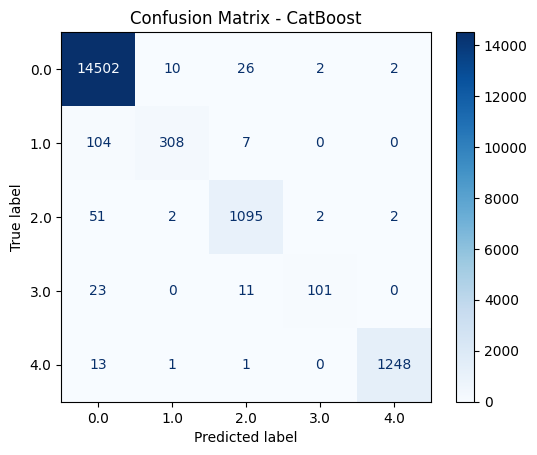

In [24]:
cm = confusion_matrix(y_test, predictions)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelx_Cat.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost")
plt.show()

- LSTM

In [30]:
modelx_lstm = Create_LSTM(2, 502, 0.019630585812292045, 'Adamax')
modelx_lstm.load_state_dict(torch.load('/kaggle/input/heatbeat_ecg_model/other/default/1/lstm_model_state.pth'))
lstm_pred, lstm_acc, lstm_f1, lstm_proba = Evaluate(modelx_lstm, test_loader, Y_test, True)

100%	548/548	Accuracy on test set: 98.21255211010222
              precision    recall  f1-score   support

           0     0.9942    0.9875    0.9909     14641
           1     0.7637    0.8579    0.8081       373
           2     0.9392    0.9541    0.9466      1134
           3     0.6667    0.9000    0.7660       100
           4     0.9881    0.9881    0.9881      1263

    accuracy                         0.9821     17511
   macro avg     0.8704    0.9375    0.8999     17511
weighted avg     0.9834    0.9821    0.9826     17511



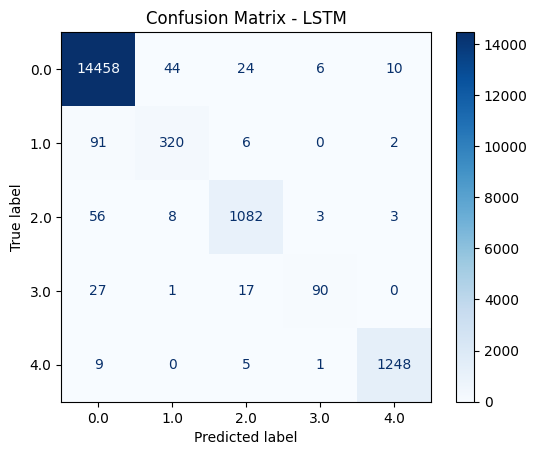

In [31]:
cm = confusion_matrix(y_test, lstm_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelx_Cat.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LSTM")
plt.show()

- CNN

In [32]:
modelx_cnn = Create_CNN(5, 509, 0.0005128042181144895, 'Nadam')
modelx_cnn.load_state_dict(torch.load('/kaggle/input/heatbeat_ecg_model/other/default/1/cnn_model_state.pth'))
cnn_pred, cnn_acc, cnn_f1, cnn_proba = Evaluate(modelx_cnn, test_loader, Y_test, True)

100%	548/548	Accuracy on test set: 98.55519387813375
              precision    recall  f1-score   support

           0     0.9935    0.9916    0.9925     14570
           1     0.8520    0.8283    0.8400       431
           2     0.9609    0.9702    0.9655      1141
           3     0.7037    0.8716    0.7787       109
           4     0.9913    0.9937    0.9925      1260

    accuracy                         0.9856     17511
   macro avg     0.9003    0.9311    0.9138     17511
weighted avg     0.9859    0.9856    0.9857     17511



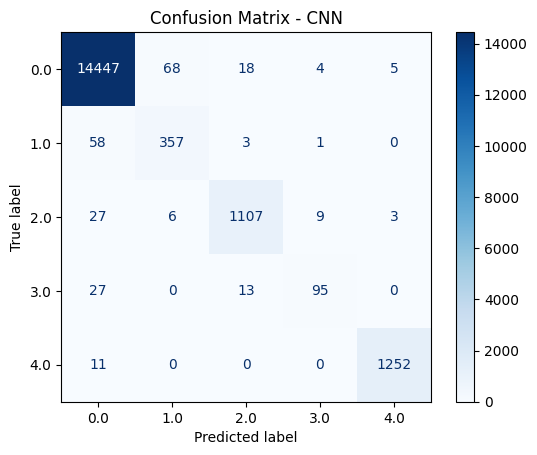

In [33]:
cm = confusion_matrix(y_test, cnn_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelx_Cat.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN")
plt.show()

- LR

In [34]:
data = pd.read_csv('/kaggle/input/heatbeat-meta-dataset/test_meta_df.csv')
meta_features_test = data.drop(['labels'], axis = 1).values
labelsx = data['labels'].values

In [37]:
loaded_model = load('/kaggle/input/heatbeat_ecg_model/other/default/1/logistic_meta_model.joblib')

pred = loaded_model.predict(meta_features_test)
print(classification_report(pred, labelsx, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9968    0.9906    0.9937     14633
         1.0     0.8258    0.9178    0.8693       377
         2.0     0.9653    0.9746    0.9699      1141
         3.0     0.7259    0.9703    0.8305       101
         4.0     0.9929    0.9960    0.9944      1259

    accuracy                         0.9883     17511
   macro avg     0.9013    0.9699    0.9316     17511
weighted avg     0.9893    0.9883    0.9886     17511



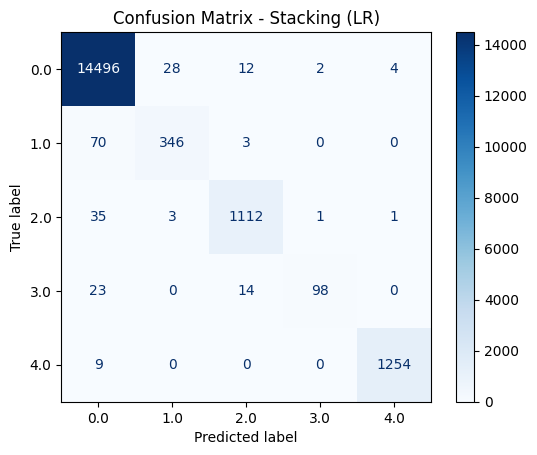

In [39]:
cm = confusion_matrix(y_test, pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelx_Cat.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Stacking (LR)")
plt.show()